# Problem 2 - OpenML, Algorithmic Performance Scaling (25 points)

This notebook explores classification tasks using datasets from OpenML, comparing Random Forest and Gradient Boosting classifiers.

---
## Setup: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


---
## Part 1: Load and Summarize Datasets [5 points]

**Task:** Select 2 datasets from OpenML with different number of output classes and summarize their attributes.

In [31]:
# Dataset 1: Choose a dataset with multi-class classification
# Dataset 2: Choose a dataset with binary classification

print("Loading datasets from OpenML...")
print("="*60)

# TODO: Load Dataset 1
dataset1 = fetch_openml(name="adult", as_frame=True)

# TODO: Load Dataset 2
dataset2 = fetch_openml(name="letter", as_frame=True)

print("Datasets loading section complete.")

Loading datasets from OpenML...
Datasets loading section complete.


In [32]:
def summarize_dataset(data, target, name):
    """Summarize attributes of a dataset."""
    # TODO: Implement dataset summarization

    # 1. Count features
    n_features = data.shape[1]

    # 2. Count instances
    n_instances = data.shape[0]

    # 3. Count classes
    n_classes = len(np.unique(target))

    # 4. Count numerical vs categorical features
    num_features = data.select_dtypes(include=['int64', 'float64']).shape[1]
    cat_features = data.select_dtypes(include=['object', 'category']).shape[1]

    summary = {
        'Dataset': name,
        'Number of Instances': n_instances,
        'Number of Features': n_features,
        'Number of Classes': n_classes,
        'Number of Numerical Features': num_features,
        'Number of Categorical Features': cat_features
    }

    feature_types = {
        'Numerical': num_features,
        'Categorical': cat_features
    }

    return summary, feature_types


# TODO: Call summarize_dataset for both datasets and display results

X1, y1 = dataset1.data, dataset1.target
X2, y2 = dataset2.data, dataset2.target

summary1, types1 = summarize_dataset(X1, y1, "Adult Income")
summary2, types2 = summarize_dataset(X2, y2, "Letter")

print("Dataset Summaries")
print("="*60)

for summary in [summary1, summary2]:
    print("\n")
    for key, value in summary.items():
        print(f"{key}: {value}")


Dataset Summaries


Dataset: Adult Income
Number of Instances: 48842
Number of Features: 14
Number of Classes: 2
Number of Numerical Features: 2
Number of Categorical Features: 12


Dataset: Letter
Number of Instances: 20000
Number of Features: 16
Number of Classes: 26
Number of Numerical Features: 16
Number of Categorical Features: 0


---
## Part 2: Training and Evaluation [15 points]

**Task:**
- Split 80% training / 20% test
- Generate 10 subsets by randomly subsampling 10%, 20%, ..., 100% of training set
- Train Random Forest and Gradient Boosting classifiers
- Measure training time and test accuracy
- Generate learning curves and training time curves

In [26]:
def prepare_data(data, target):
    """Prepare data for training - handle categorical variables and encode labels."""
    # TODO: Handle encoding of categorical features and target labels

    X = data.copy()

    # One-hot encode categorical columns (if any)
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    if len(cat_cols) > 0:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=False)

    # Encode target labels
    le = LabelEncoder()
    y = le.fit_transform(np.array(target))

    return X, y

    return data, target

In [27]:
def run_experiment(X, y, dataset_name, random_state=42):
    """
    Run the training experiment with 10 different training set sizes.

    Returns:
        results: dict containing accuracies and training times for both classifiers
    """
    # TODO: Split data into 80% training and 20% test

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=random_state,
        stratify=y
    )

    # TODO: Initialize results dictionary to store metrics
    results = {
        "dataset": dataset_name,
        "train_sizes_pct": [],
        "train_sizes_n": [],
        "rf_train_time": [],
        "rf_test_acc": [],
        "gb_train_time": [],
        "gb_test_acc": []
    }


    # Training percentages
    percentages = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]

    print(f"\n{'='*70}")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*70}")

    for pct in percentages:
        if pct == 100:
            X_sub, y_sub = X_train, y_train
            subset_size = X_train.shape[0]
        else:
            frac = pct / 100.0
            subset_size = int(np.floor(frac * X_train.shape[0]))
            subset_size = max(1, subset_size)

            X_sub, _, y_sub, _ = train_test_split(
                X_train, y_train,
                train_size=subset_size,
                random_state=random_state,
                stratify=y_train
            )

        # TODO: Train Random Forest and measure time/accuracy
        rf = RandomForestClassifier(
            n_estimators=200,
            random_state=random_state,
            n_jobs=-1
        )

        t0 = time.perf_counter()
        rf.fit(X_sub, y_sub)
        rf_time = time.perf_counter() - t0

        rf_pred = rf.predict(X_test)
        rf_acc = accuracy_score(y_test, rf_pred)

        # TODO: Train Gradient Boosting and measure time/accuracy
        gb = GradientBoostingClassifier(
            random_state=random_state
        )

        t0 = time.perf_counter()
        gb.fit(X_sub, y_sub)
        gb_time = time.perf_counter() - t0

        gb_pred = gb.predict(X_test)
        gb_acc = accuracy_score(y_test, gb_pred)

        # TODO: Store results
        results["train_sizes_pct"].append(pct)
        results["train_sizes_n"].append(subset_size)
        results["rf_train_time"].append(rf_time)
        results["rf_test_acc"].append(rf_acc)
        results["gb_train_time"].append(gb_time)
        results["gb_test_acc"].append(gb_acc)

        print(f"\nTrain subset: {pct}%  (n={subset_size})")
        print(f"  RF -> time: {rf_time:.4f}s | test acc: {rf_acc:.4f}")
        print(f"  GB -> time: {gb_time:.4f}s | test acc: {gb_acc:.4f}")

    return results

In [28]:
def plot_results(results, dataset_name):
    """
    Generate learning curves and training time curves.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # TODO: Extract data from results dictionary

    train_sizes = results["train_sizes_n"]

    rf_acc = results["rf_test_acc"]
    gb_acc = results["gb_test_acc"]

    rf_time = results["rf_train_time"]
    gb_time = results["gb_train_time"]

    # TODO: Plot Learning Curves (Accuracy vs Data Size) on axes[0]

    axes[0].plot(train_sizes, rf_acc, marker='o', label='Random Forest')
    axes[0].plot(train_sizes, gb_acc, marker='o', label='Gradient Boosting')

    axes[0].set_xlabel("Training Data Size (Number of Samples)")
    axes[0].set_ylabel("Test Accuracy")
    axes[0].set_title(f"{dataset_name} - Learning Curve")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # TODO: Plot Training Time Curves (Time vs Data Size) on axes[1]

    axes[1].plot(train_sizes, rf_time, marker='o', label='Random Forest')
    axes[1].plot(train_sizes, gb_time, marker='o', label='Gradient Boosting')

    axes[1].set_xlabel("Training Data Size (Number of Samples)")
    axes[1].set_ylabel("Training Time (seconds)")
    axes[1].set_title(f"{dataset_name} - Training Time Curve")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


Dataset: Adult Census Income

Train subset: 1%  (n=390)
  RF -> time: 0.3905s | test acc: 0.8215
  GB -> time: 0.1973s | test acc: 0.8258

Train subset: 2%  (n=781)
  RF -> time: 0.5200s | test acc: 0.8324
  GB -> time: 0.2580s | test acc: 0.8403

Train subset: 3%  (n=1172)
  RF -> time: 0.5821s | test acc: 0.8319
  GB -> time: 0.3564s | test acc: 0.8446

Train subset: 4%  (n=1562)
  RF -> time: 0.6540s | test acc: 0.8341
  GB -> time: 0.4199s | test acc: 0.8474

Train subset: 5%  (n=1953)
  RF -> time: 0.7565s | test acc: 0.8381
  GB -> time: 0.5115s | test acc: 0.8505

Train subset: 6%  (n=2344)
  RF -> time: 0.8397s | test acc: 0.8364
  GB -> time: 0.6113s | test acc: 0.8515

Train subset: 7%  (n=2735)
  RF -> time: 0.9202s | test acc: 0.8350
  GB -> time: 0.7079s | test acc: 0.8524

Train subset: 8%  (n=3125)
  RF -> time: 1.4518s | test acc: 0.8370
  GB -> time: 1.5460s | test acc: 0.8532

Train subset: 9%  (n=3516)
  RF -> time: 1.1119s | test acc: 0.8405
  GB -> time: 0.8615s |

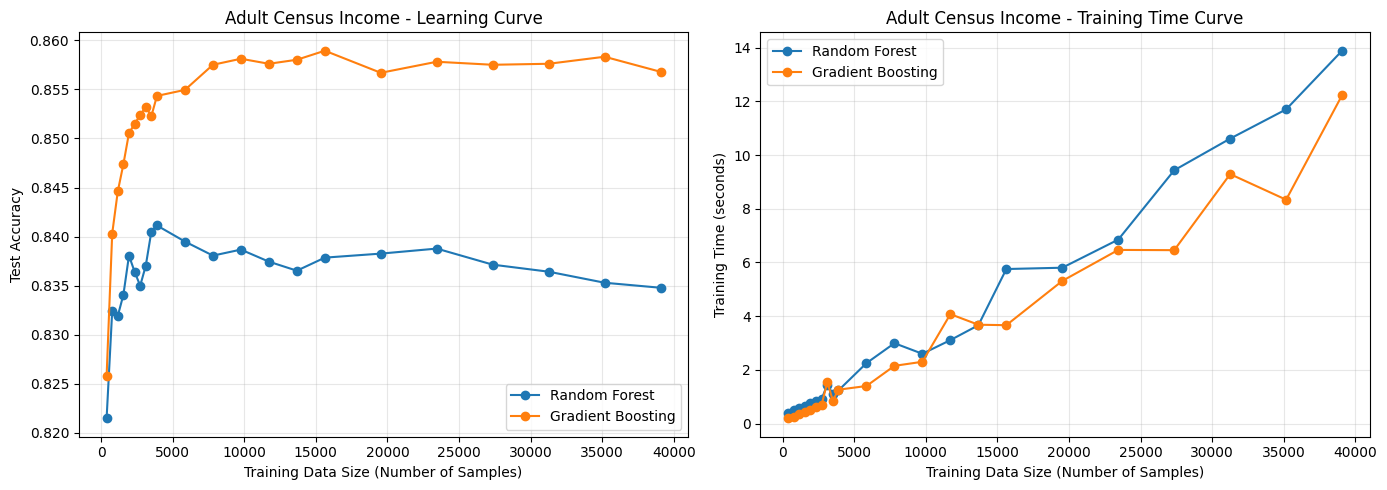

In [21]:
# TODO: Run Experiment and Plot for Dataset 1
X1, y1 = prepare_data(dataset1.data, dataset1.target)
results1 = run_experiment(X1, y1, "Adult Census Income")
plot_results(results1, "Adult Census Income")


Dataset: Letter

Train subset: 1%  (n=160)
  RF -> time: 1.6822s | test acc: 0.5627
  GB -> time: 7.0862s | test acc: 0.4647

Train subset: 2%  (n=320)
  RF -> time: 0.5152s | test acc: 0.7013
  GB -> time: 3.5189s | test acc: 0.6200

Train subset: 3%  (n=480)
  RF -> time: 0.4931s | test acc: 0.7508
  GB -> time: 5.5821s | test acc: 0.6880

Train subset: 4%  (n=640)
  RF -> time: 0.5562s | test acc: 0.7728
  GB -> time: 4.8102s | test acc: 0.7222

Train subset: 5%  (n=800)
  RF -> time: 0.6300s | test acc: 0.7910
  GB -> time: 6.7519s | test acc: 0.7485

Train subset: 6%  (n=960)
  RF -> time: 0.6625s | test acc: 0.8055
  GB -> time: 5.9367s | test acc: 0.7722

Train subset: 7%  (n=1120)
  RF -> time: 1.2132s | test acc: 0.8223
  GB -> time: 7.2460s | test acc: 0.7817

Train subset: 8%  (n=1280)
  RF -> time: 0.7357s | test acc: 0.8320
  GB -> time: 8.4726s | test acc: 0.8053

Train subset: 9%  (n=1440)
  RF -> time: 0.7896s | test acc: 0.8455
  GB -> time: 8.3851s | test acc: 0.8143

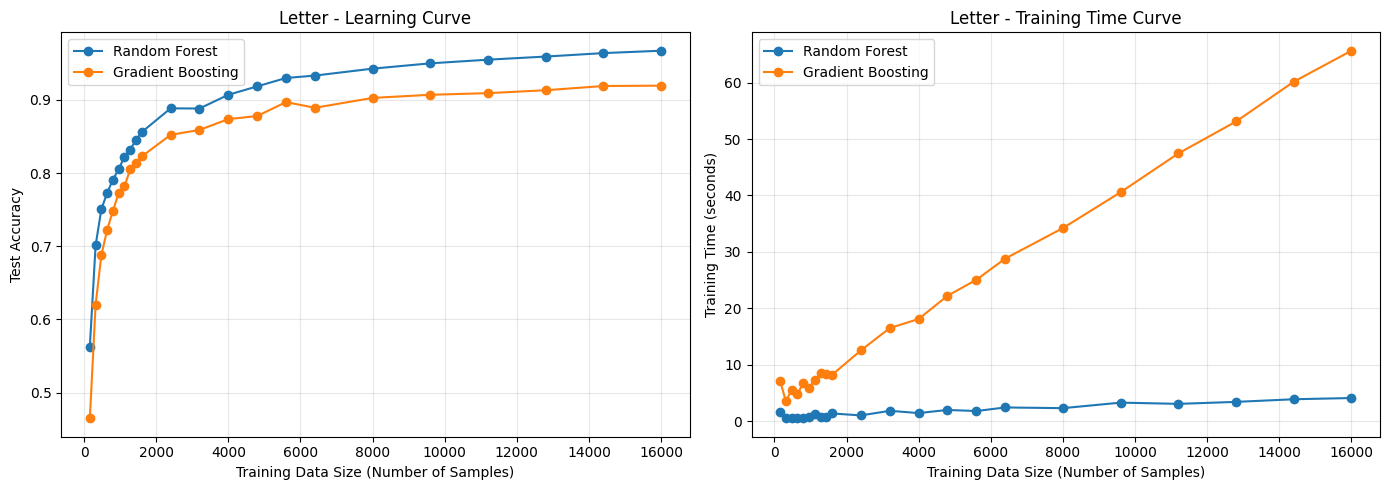

In [34]:
# TODO: Run Experiment and Plot for Dataset 2
X2, y2 = prepare_data(dataset2.data, dataset2.target)
results2 = run_experiment(X2, y2, "Letter")
plot_results(results2, "Letter")

---
## Part 3: Analysis and Observations [5 points]

**Task:** Write three main observations about:
1. Scaling of training time
2. Comparison of accuracy between the two classifiers
3. Learning curve behavior

### Your Observations:

**Observation 1: Training Time Scaling**
- Training time increases approximately linearly with the size of the training data for both classifiers, but the magnitude differs significantly across datasets.
- For the Adult dataset, both Random Forest (RF) and Gradient Boosting (GB) scale moderately with data size. At 100% of training data (~39k samples), RF requires ~13.9 seconds while GB requires ~12.2 seconds. Their training times are comparable, with RF slightly slower at large sizes.
- For the Letter dataset, the difference is much more pronounced. At full training size (~16k samples), RF takes only ~4.1 seconds, whereas GB requires ~65.6 seconds. This indicates that Gradient Boosting scales much more aggressively with data size in multi-class settings (26 classes), while Random Forest remains computationally efficient.
- Overall, Random Forest demonstrates better computational scalability, especially for multi-class problems.

**Observation 2: Accuracy Comparison**
- On the Adult dataset (binary classification): Gradient Boosting consistently achieves higher test accuracy.

  - GB stabilizes around ~0.857–0.859.
  - RF stabilizes around ~0.835–0.841.

- Thus, Gradient Boosting outperforms Random Forest in terms of predictive accuracy for the binary classification problem.

- On the Letter dataset (26-class classification): Random Forest significantly outperforms Gradient Boosting.

  - RF reaches ~0.967 test accuracy at full data.
  - GB plateaus around ~0.919.

- In multi-class settings with many classes, Random Forest achieves substantially better accuracy.

- Therefore:
  - Binary dataset: Gradient Boosting performs better.
  - Multi-class dataset: Random Forest performs better.

**Observation 3: Learning Curve Behavior**
- For both datasets, accuracy improves rapidly at small training sizes and then plateaus as more data is added.

- On the Adult dataset, accuracy improvements diminish after ~20–30% of training data, indicating the model reaches its performance limit relatively early. The learning curves flatten, suggesting low additional benefit from further increasing data size.

- On the Letter dataset, accuracy steadily increases with more data, especially for Random Forest. The improvement remains visible even beyond 50% of training data, indicating that additional data continues to reduce variance and improve generalization.

- This demonstrates: Adult dataset (Binary Classification) shows early saturation. Letter dataset (Multi-Class Classification) benefits more consistently from additional training data. Random Forest appears more data-efficient in high-class-count settings.